- First, infill LGM ice using lgm_regrid LGMR notebook
- Then, use ice sheet adjustment LGMR notebook to:
    - make sea ice be 100% where there are ice sheets for LGM and for Late Holocene (Antarctic)
- After that, load LGM sea ice dataset here and infill the sea ice in remaining new ocean area

In [197]:
#!/usr/bin/env python
# coding: utf-8

#########
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import copy
import pandas as pd
import seaborn as sns
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')


import metpy
import metpy.calc as mpcalc

In [198]:
## load sea ice data
path = '/home/disk/sipn/vcooper/nobackup/lgm/LGMR/'
# holo_ice_adj = xr.open_dataset(path + 'LGMR_SIC_holo_0-4ka_ensmean_ice6g-adj.nc')
lgm_ice_adj = xr.open_dataset(path + 'LGMR_SIC_lgm_19-23ka_ensmean_ice6g-adj.nc')

## load SST data infilled
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
fname = 'LGMR_lgm_SST_monthly_climo_merged.nc'
lgm_sst_climo = xr.open_dataset(path + fname)

## load ice6g
ice6g = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/peltier_lgm-mask/' + 'I6_C.VM5a_1deg.21.nc')
ice6g_0 = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/peltier_lgm-mask/' + 'I6_C.VM5a_1deg.0.nc')

In [199]:
## regrid the lgm sst onto the sea ice grid
## this SST will be used to determine the icefrac in "new ocean" areas
newgrid = lgm_ice_adj # desired grid
newgrid['mask'] = xr.where(~np.isnan(newgrid.icefrac[0]),1,0)
data_for_regridding = lgm_sst_climo
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',#ignore_degenerate=True,
                         periodic=True,
                         extrap_method = 'inverse_dist',extrap_num_src_pnts=16,
                         filename='bilinear_sst_to_ice_perLGMR.nc',
                         reuse_weights=True)

lgm_sst_climo_regrid = regridder(lgm_sst_climo)

In [200]:
## regrid ice6g so we can identify what needs infilled

newgrid = lgm_ice_adj.icefrac[0] # desired grid
data_for_regridding = ice6g
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sftlf),1,0)

regridder_ice6g = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
#                          extrap_method='inverse_dist',extrap_num_src_pnts=64,
                         filename='bilinear_noextrapc.nc',
                         reuse_weights=True)

ice6g_regrid = regridder_ice6g(data_for_regridding)
ice6g_0_regrid = regridder_ice6g(ice6g_0)


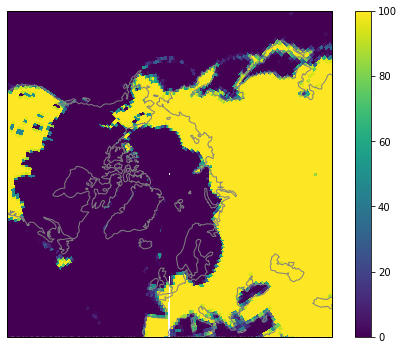

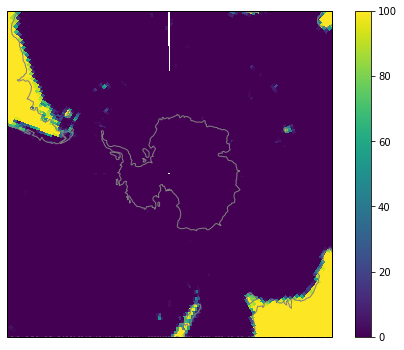

In [201]:
## already used ice_sheet_adjustment ipynb to make sea ice be 100% when ice sheet is present
## now, highlight sea level change areas in arctic that need infilled, i.e.,
## new ocean areas that need to have sea ice

## plot shows land area in LGM that is NOT ice sheet

ds = ice6g.sftlf - ice6g.sftgif.values
cmap_set = 'viridis'

## Arctic
proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 38, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

## Antarctic
proj = ccrs.SouthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -38, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

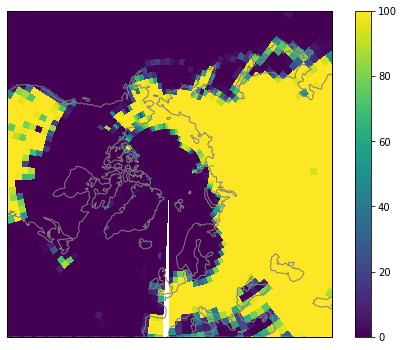

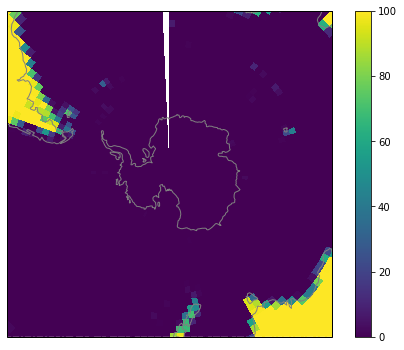

In [202]:
## regridded version

ds = ice6g_regrid.sftlf - ice6g_regrid.sftgif.values
cmap_set = 'viridis'

## Arctic
proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 38, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

## Antarctic
proj = ccrs.SouthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -38, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

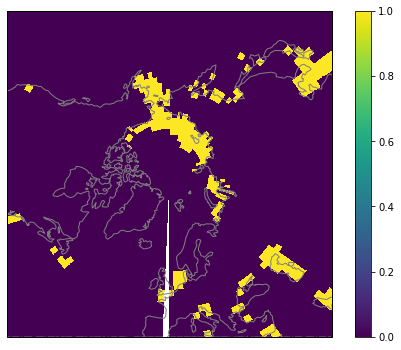

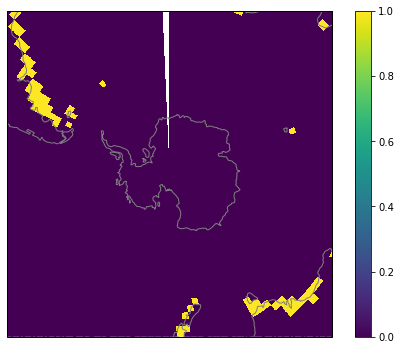

In [203]:
## regridded version

ds = ice6g_regrid.sftlf - ice6g_regrid.sftgif.values - ice6g_0_regrid.sftlf.values
ds = xr.where(ds > 20, 1,0)
cmap_set = 'viridis'

## Arctic
proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 38, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

## Antarctic
proj = ccrs.SouthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -38, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

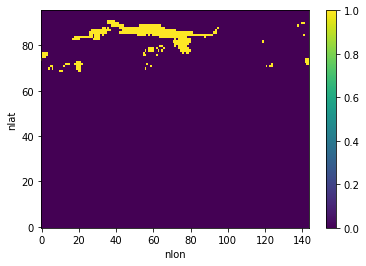

In [205]:
## only target northern hemisphere spots
## -- where landfrac change at least 20% at lats > 40
## -- but expand to where landfrac > 0 at lats > 65 because
## -- of some tricky spots particular in [barents/kara] sea

infillzone = ice6g_regrid.sftlf - ice6g_regrid.sftgif.values - ice6g_0_regrid.sftlf.values
infillzone = infillzone/100. ## convert to fraction
infillmask_all = xr.where((infillzone > 0.2) & (infillzone.lat > 40), 1, 0)
infillmask_highlat = xr.where((infillzone > 0) & (infillzone.lat > 65), 1, 0)
infillmask = xr.where(infillmask_highlat > infillmask_all, infillmask_highlat, infillmask_all)
infillmask.plot()

In [233]:
%%time
## apply modified Hurrell correction to icefrac based on SST
## and 

## store new data in this dataset
icecombo_all = lgm_ice_adj.icefrac.to_dataset().copy(
    data={'icefrac':np.zeros_like(lgm_ice_adj.icefrac.values)})

for msel in range(12):
    ## these "prediddle"names are lazy coding, copied from other place. names meaningless here.
    sst_prediddle_adj = lgm_sst_climo_regrid.sst[msel]
    sic_prediddle_adj = lgm_ice_adj.icefrac[msel]

    ## ADJUSTED HURRELL CORRECTION: this brings icefrac UP to the icemax, instead of capping at icemax
    ## but is only applied to the infill areas.
    ## the capping will happen later everywhere during the prep-cam-bc step
    
    # ; 5) Hurrell et al correction to ice frac (if -1.8 < SST < 4.97)
    # ice_max = 100.*(0.729-(SST+1.8)/9.328)^(1./3.)
    # SEAICE = where((SST.gt.-1.8).and.(SST.lt.4.97).and.(SEAICE.gt.ice_max), ice_max, SEAICE)
    ice_max = (0.729-(sst_prediddle_adj+1.8)/9.328)**(1./3.)
    sic_prediddle_adj = xr.where((sst_prediddle_adj > -1.8) &  ##
                                 (sst_prediddle_adj < 4.97) & 
                                 (infillmask),# & 
    #                                     (sic_prediddle_adj > ice_max), ## this is the change
                                         ice_max, sic_prediddle_adj)

    ## Extra correction to make everything colder SST than -1.8 be 100% sea ice
    sic_prediddle_adj = xr.where((sst_prediddle_adj < -1.8) & (infillmask), 1., sic_prediddle_adj)
    
    latmin=68
    for imer,val in enumerate(sic_prediddle_adj.transpose('nlon',...)):
        valnh = val.where(val.lat > latmin)

        ## check maximum ice poleward and equatorward, along meridian
        max_ice_poleward = np.array([valnh[j:].max() for j in range(len(valnh))])
        max_ice_equatorward = np.array([valnh[0:j+1].max() for j in range(len(valnh))])

        ## ice ceiling is maximum value ice will increase to. don't go below the original
        ## ice value, and don't go above the maximum SIC poleward of position
        ice_ceiling = np.array([np.max([p,v]) for p,v in zip(max_ice_poleward,valnh)])
        max_ice_equatorward = np.where((max_ice_equatorward > valnh) & (max_ice_equatorward > ice_ceiling), 
                                   ice_ceiling, max_ice_equatorward)

        val = xr.where(val.lat > latmin, max_ice_equatorward, val)
        sic_prediddle_adj[:,imer] = val
        
    ## smoothing the infill; treat land as ice for smoothing, otherwise always reduces at coast
    forsmoothing = np.max([sic_prediddle_adj,ice6g_regrid.sftlf/100],axis=0,keepdims=1).squeeze()
    op = plt.imshow(mpcalc.smooth_gaussian(forsmoothing,5))
    smoothed = op.get_array().data
    plt.close()

    ## set mask for where to apply the smoothed data
    infillmask_smoothing = xr.where((infillzone > 0.001) & (infillzone.lat > 60), 1, 0)

#     sic_prediddle_adj2 = xr.where((infillmask_smoothing),
#                          smoothed, sic_prediddle_adj)
    #     icecombo_all.icefrac[msel] = sic_prediddle_adj2.values

    ## final version of infill areas: mean of smoothed and unsmoothed (avoids sharp edges
    ## that otherwise arise at boundary of where smoothing is not applied bc no infilling
    ## required there)
    sic_prediddle_adj3 = xr.where((infillmask_smoothing),
                          np.mean([smoothed,sic_prediddle_adj],axis=0), sic_prediddle_adj)
    
    icecombo_all.icefrac[msel] = sic_prediddle_adj3.values
    
    print(msel, ' done')

0  done
1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10  done
11  done
CPU times: user 2min 22s, sys: 27.1 ms, total: 2min 23s
Wall time: 2min 22s


In [232]:
# icecombo_all_0 = copy.deepcopy(icecombo_all)
# icecombo_all_2 = copy.deepcopy(icecombo_all)

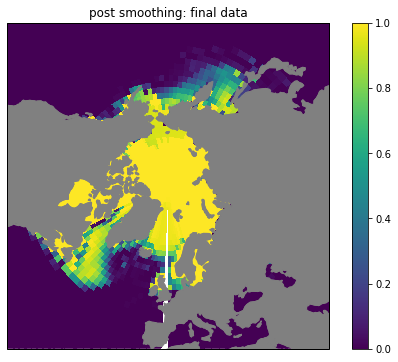

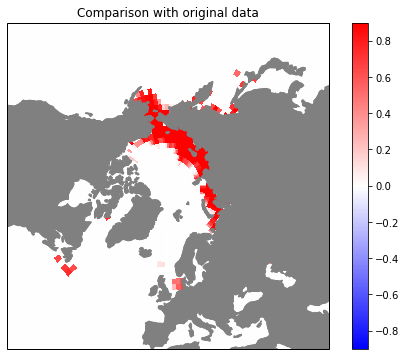

In [234]:
# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = icecombo_all.icefrac[msel]

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
plt.title('post smoothing: final data')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = icecombo_all.icefrac[msel] - lgm_ice_adj.icefrac[msel].values

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
               cmap='bwr')
plt.title('Comparison with original data')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

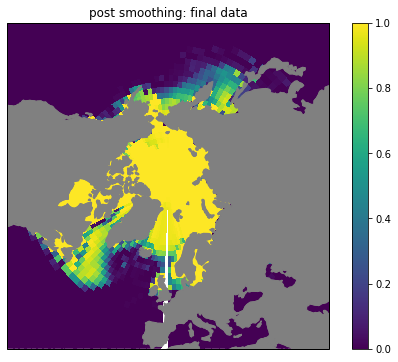

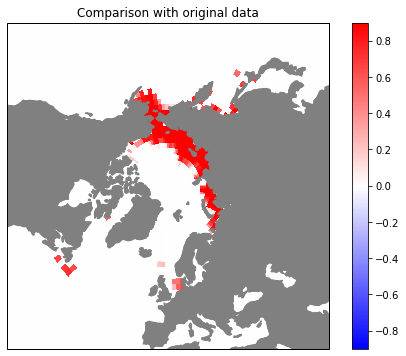

In [230]:
# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = icecombo_all.icefrac[msel]

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
plt.title('post smoothing: final data')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = icecombo_all.icefrac[msel] - lgm_ice_adj.icefrac[msel].values

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
               cmap='bwr')
plt.title('Comparison with original data')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

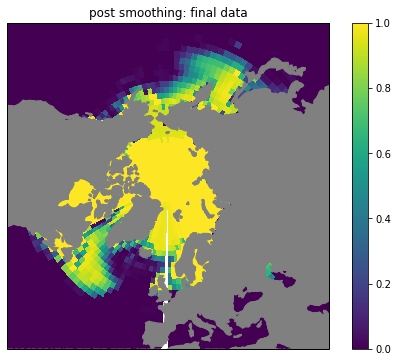

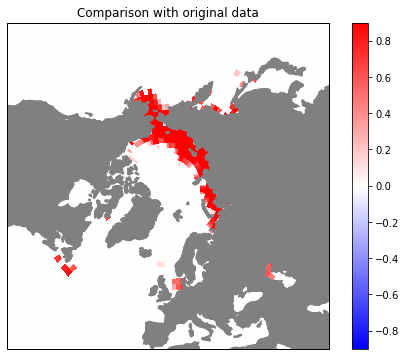

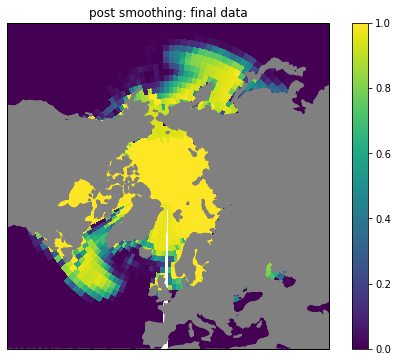

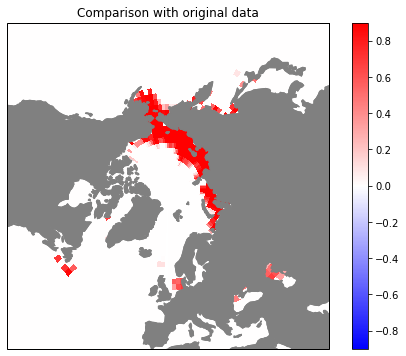

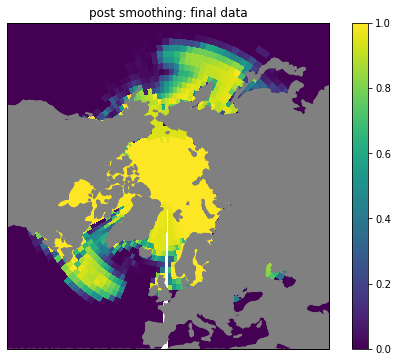

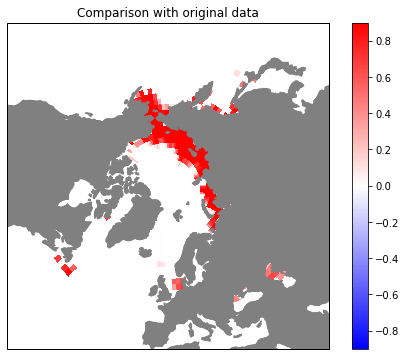

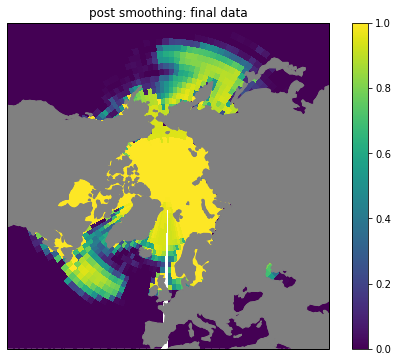

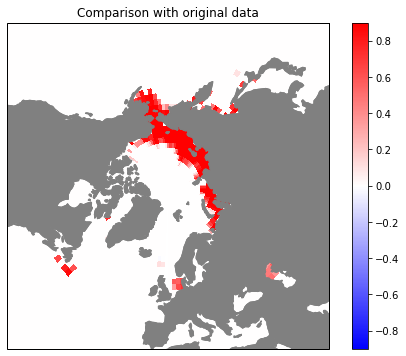

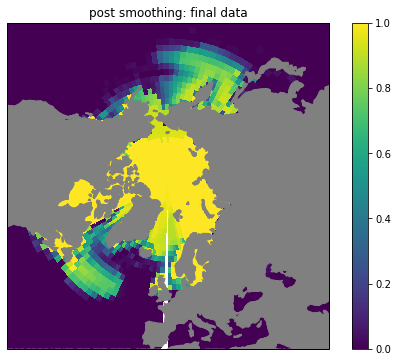

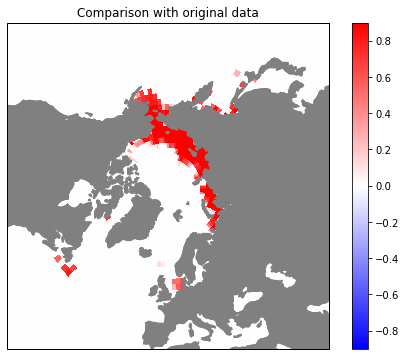

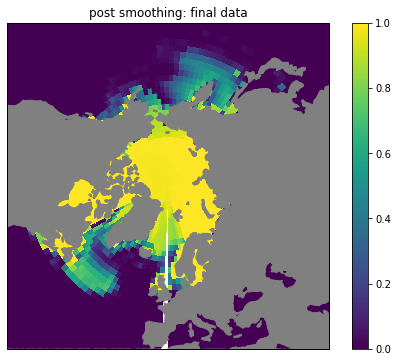

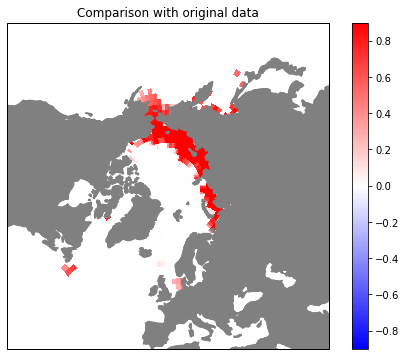

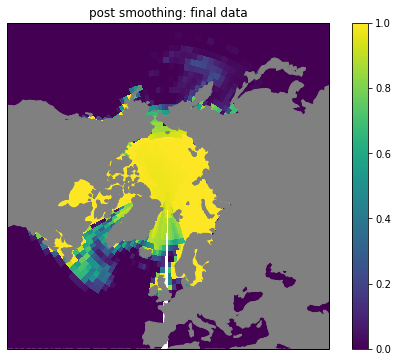

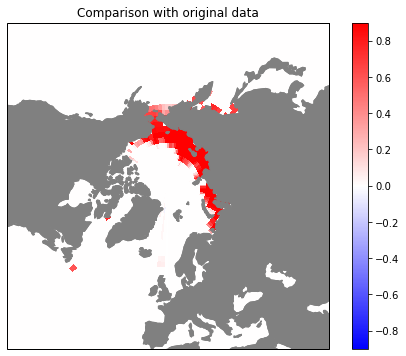

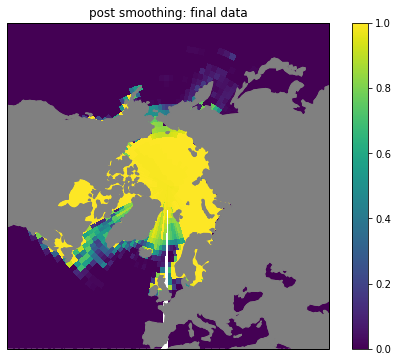

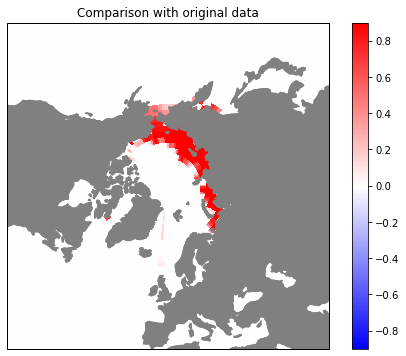

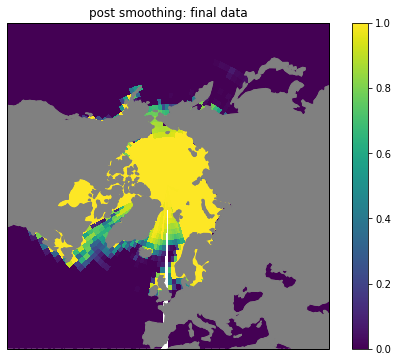

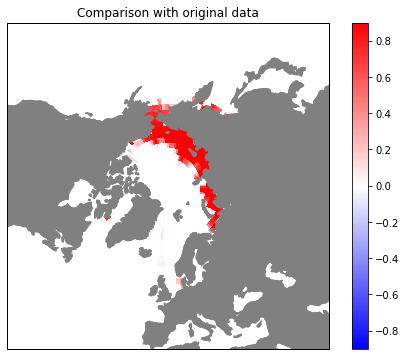

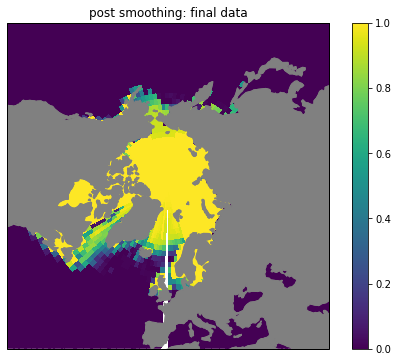

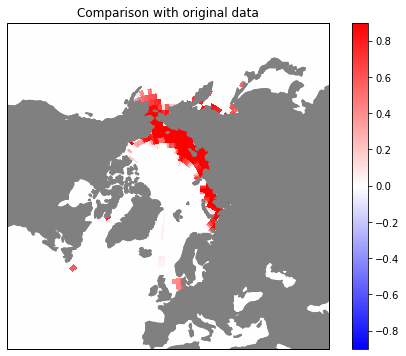

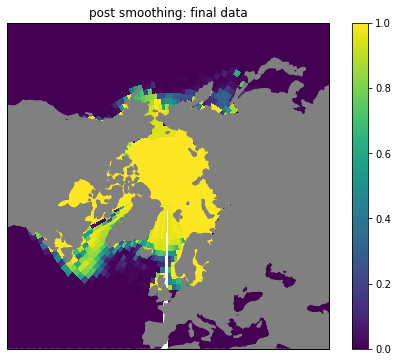

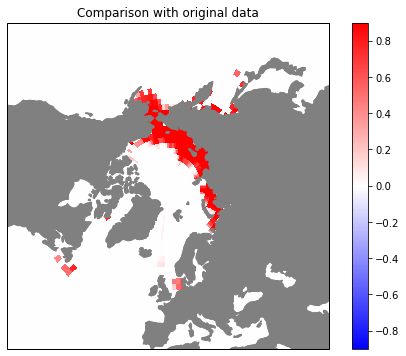

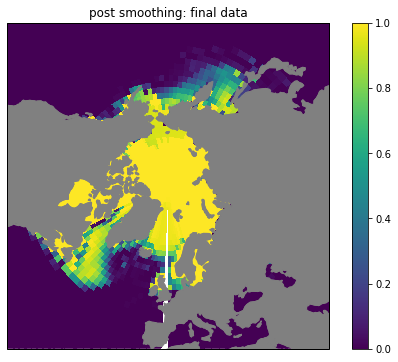

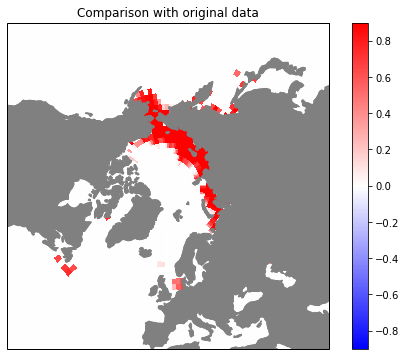

In [236]:
for msel in range(12):
    # PLOTTING TO CHECK RESULTS
    proj = ccrs.NorthPolarStereo()

    ds = icecombo_all.icefrac[msel]

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')
    plt.title('post smoothing: final data')
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()

    # PLOTTING TO CHECK RESULTS
    proj = ccrs.NorthPolarStereo()

    ds = icecombo_all.icefrac[msel] - lgm_ice_adj.icefrac[msel].values

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
                   cmap='bwr')
    plt.title('Comparison with original data')
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()

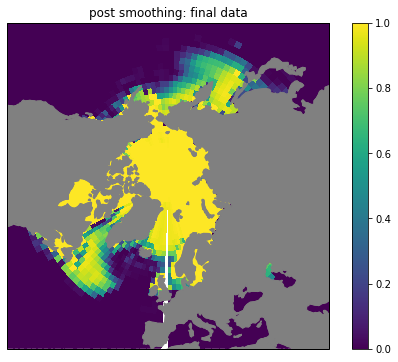

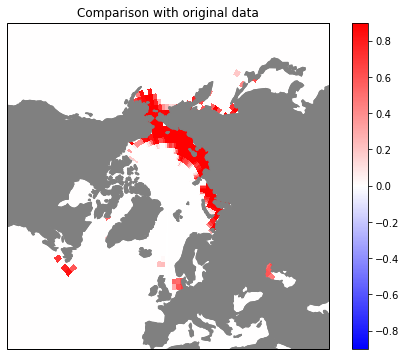

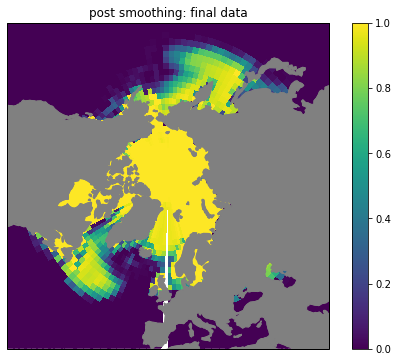

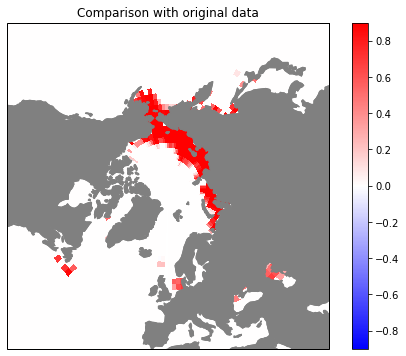

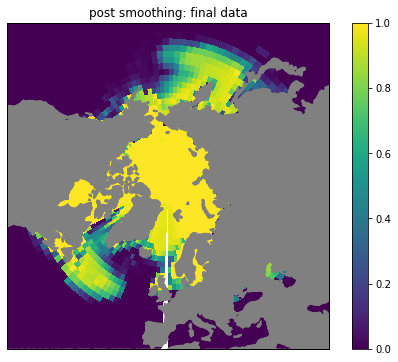

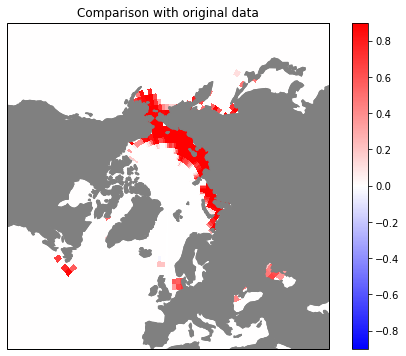

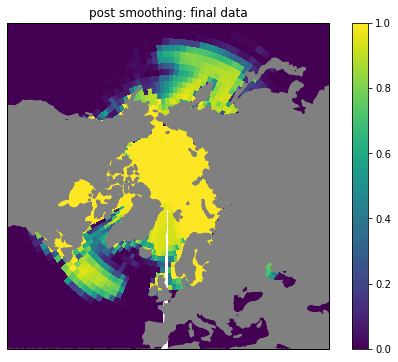

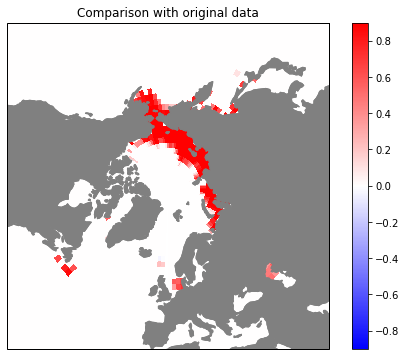

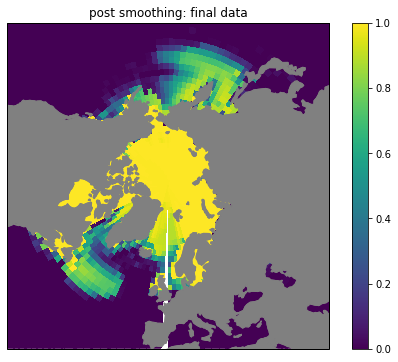

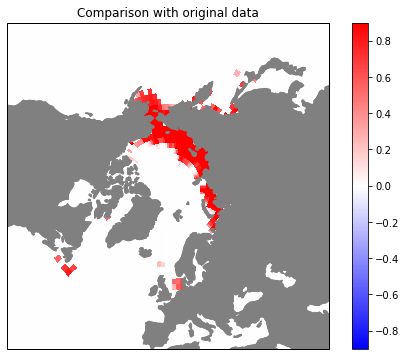

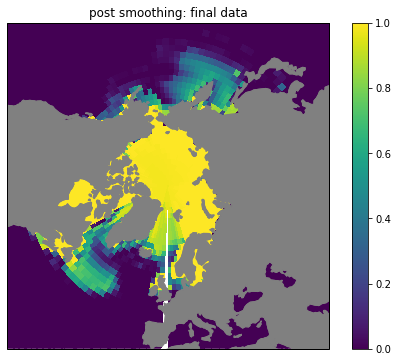

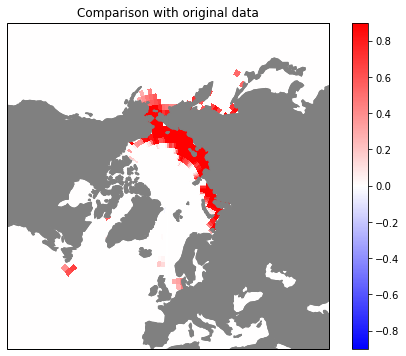

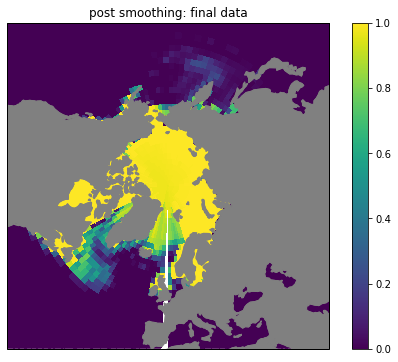

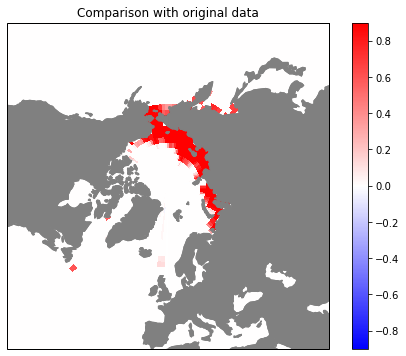

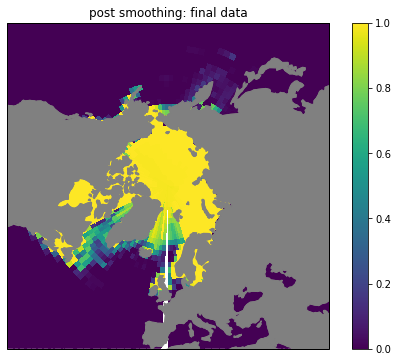

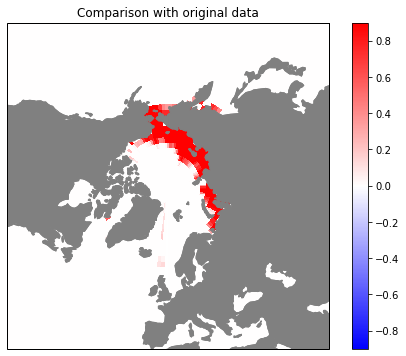

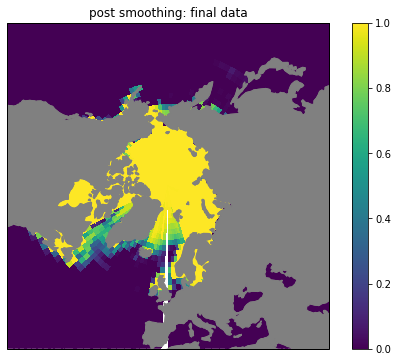

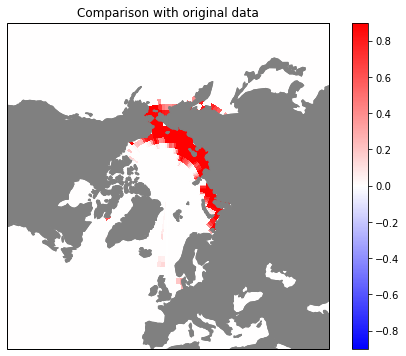

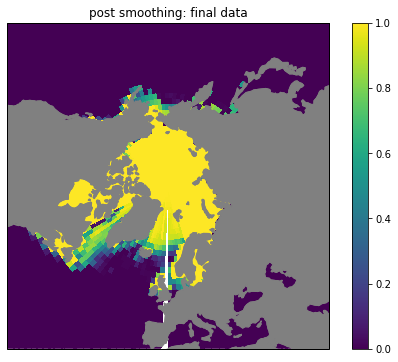

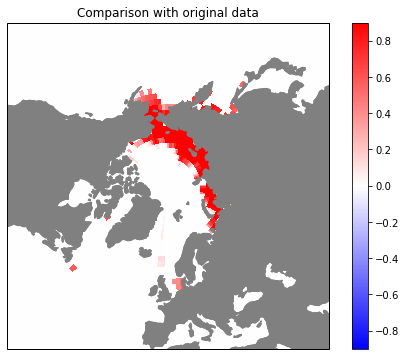

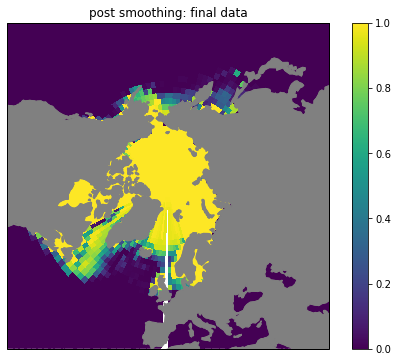

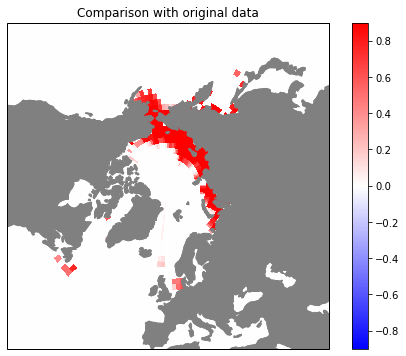

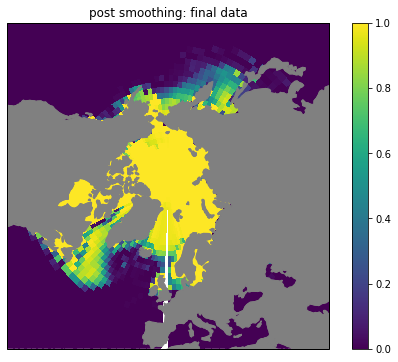

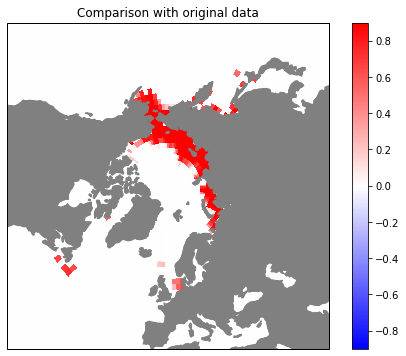

In [231]:
for msel in range(12):
    # PLOTTING TO CHECK RESULTS
    proj = ccrs.NorthPolarStereo()

    ds = icecombo_all.icefrac[msel]

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')
    plt.title('post smoothing: final data')
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()

    # PLOTTING TO CHECK RESULTS
    proj = ccrs.NorthPolarStereo()

    ds = icecombo_all.icefrac[msel] - lgm_ice_adj.icefrac[msel].values

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
                   cmap='bwr')
    plt.title('Comparison with original data')
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()

In [237]:
path='/home/disk/sipn/vcooper/nobackup/lgm/cesm2lgm/'
fname = 'b.e21.B1850CAM5CLM50SP.f09_g17.21ka.01.cam.0451-0500.climo.nc'
cesm2lgm = xr.open_dataset(path + fname)

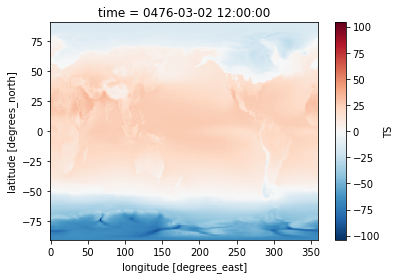

In [265]:
(cesm2lgm.TS[7]-273).plot()

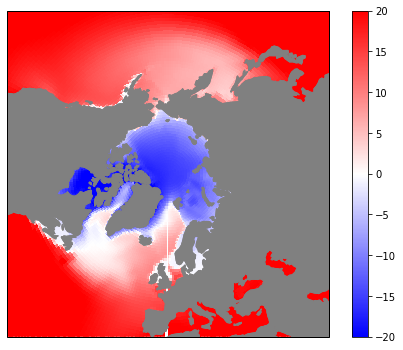

In [277]:
# for msel in range(2): 
# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

#     ds = icecombo_all.icefrac[msel]
ds = cesm2lgm.TS[7]-273

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='bwr',vmin=-20,vmax=20)
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()


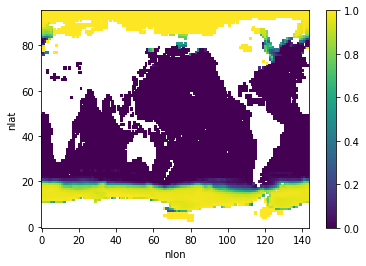

In [211]:
# sic_prediddle_adj.where(ice6g_0_regrid.sftlf < 0.1).plot()

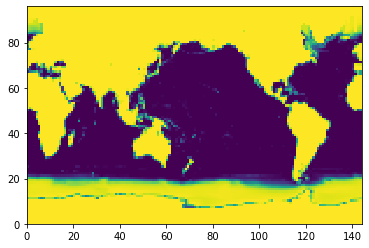

In [212]:
plt.pcolormesh(np.max([sic_prediddle_adj,ice6g_regrid.sftlf/100],axis=0,keepdims=1).squeeze())

forsmoothing = np.max([sic_prediddle_adj,ice6g_regrid.sftlf/100],axis=0,keepdims=1).squeeze()

In [218]:
# op = plt.imshow(mpcalc.smooth_gaussian(sic_prediddle_adj.values,5))
op = plt.imshow(mpcalc.smooth_gaussian(forsmoothing,5))
smoothed = op.get_array().data
plt.close()
plt.show()
# op = plt.imshow(mpcalc.smooth_n_point(sic_prediddle_adj.where(ice6g_0_regrid.sftlf < 0.2).values,5,1))
# plt.show()

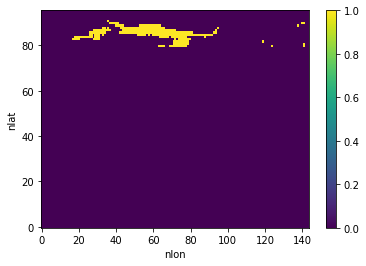

In [214]:
infillmask_smoothing = xr.where((infillzone > 0.01) & (infillzone.lat > 60), 1, 0)
infillmask_smoothing.plot()

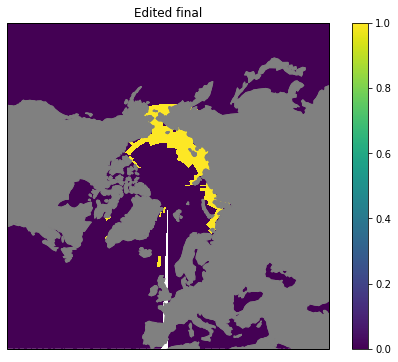

In [219]:
proj = ccrs.NorthPolarStereo()

#     ds = icecombo_all.icefrac[msel]
ds = infillmask_smoothing

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
plt.title('Edited final')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

In [221]:
sic_prediddle_adj2 = xr.where((infillmask_smoothing),# & (smoothed > sic_prediddle_adj), 
                              smoothed, sic_prediddle_adj)

sic_prediddle_adj3 = xr.where((infillmask_smoothing),# & (smoothed > sic_prediddle_adj), 
                              np.mean([smoothed,sic_prediddle_adj],axis=0), sic_prediddle_adj)

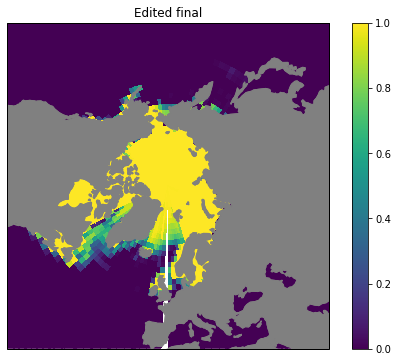

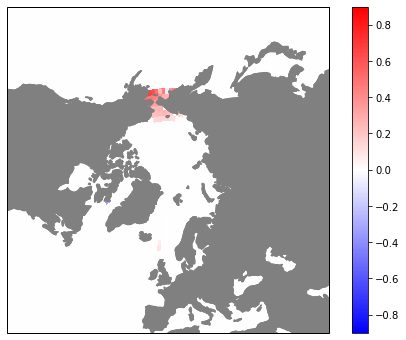

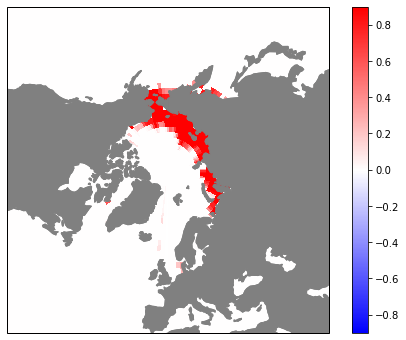

In [222]:
# for msel in range(2): 
# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

#     ds = icecombo_all.icefrac[msel]
ds = sic_prediddle_adj2

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
plt.title('Edited final')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = sic_prediddle_adj2 - sic_prediddle_adj

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
               cmap='bwr')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

proj = ccrs.NorthPolarStereo()

ds = sic_prediddle_adj2 - lgm_ice_adj.icefrac[msel]

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
               cmap='bwr')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

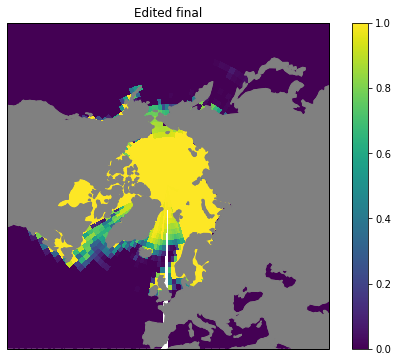

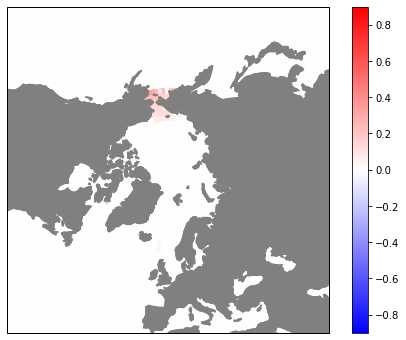

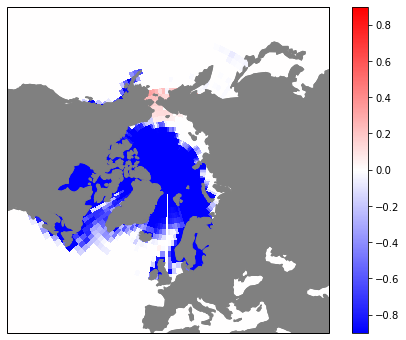

In [223]:
# for msel in range(2): 
# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

#     ds = icecombo_all.icefrac[msel]
ds = sic_prediddle_adj3

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
plt.title('Edited final')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = ds - sic_prediddle_adj

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
               cmap='bwr')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

proj = ccrs.NorthPolarStereo()

ds = ds - lgm_ice_adj.icefrac[msel]

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
               cmap='bwr')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

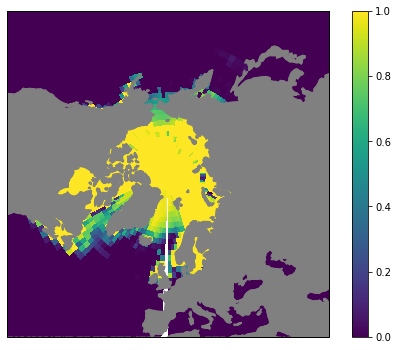

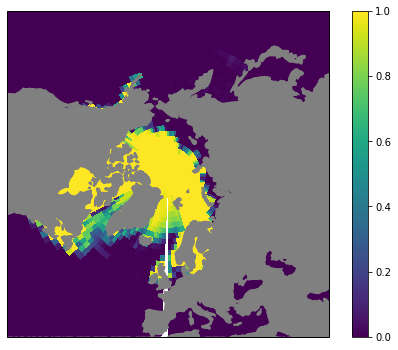

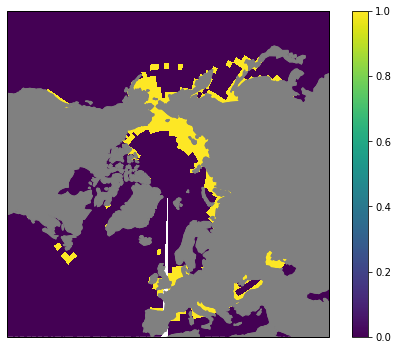

In [81]:
# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = sic_prediddle_adj

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = lgm_ice_adj.icefrac[msel]

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

ds = infillmask

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

In [84]:
# # testing ground
# latmin=68
# for imer,val in enumerate(sic_prediddle_adj.transpose('nlon',...)):
#     valnh = val.where(val.lat > latmin)
    
#     ## check maximum ice poleward and equatorward, along meridian
#     max_ice_poleward = np.array([valnh[j:].max() for j in range(len(valnh))])
#     max_ice_equatorward = np.array([valnh[0:j+1].max() for j in range(len(valnh))])
    
#     ## ice ceiling is maximum value ice will increase to. don't go below the original
#     ## ice value, and don't go above the maximum SIC poleward of position
#     ice_ceiling = np.array([np.max([p,v]) for p,v in zip(max_ice_poleward,valnh)])
#     max_ice_equatorward = np.where((max_ice_equatorward > valnh) & (max_ice_equatorward > ice_ceiling), 
#                                ice_ceiling, max_ice_equatorward)
    
#     val = xr.where(val.lat > latmin, max_ice_equatorward, val)
# #     cambc_ice6g_adjmer[it,:,imer] = val
#     sic_prediddle_adj[:,imer] = val

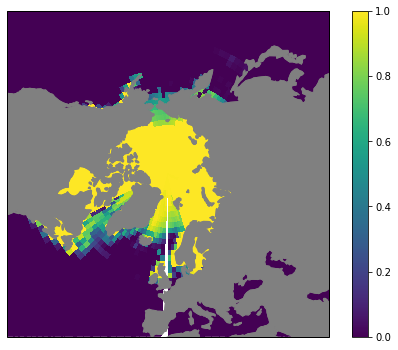

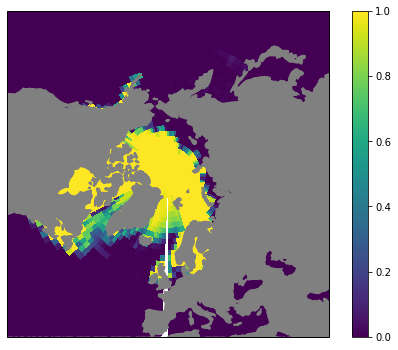

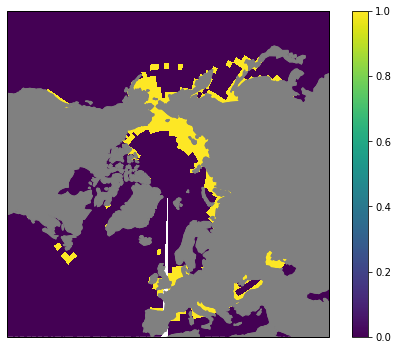

In [85]:
# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = sic_prediddle_adj

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = lgm_ice_adj.icefrac[msel]

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

ds = infillmask

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
# plt.title('Original SST from LGM on ice grid')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

In [ ]:
############# ICE SHEET ADJUSTMENTS ######
# THIS VERSION HAS NOT GONE THROUGH HURRELL ADJUSTMENTS
## Consider including the ice_sheet_adjustment in this script for the ensemble members

# path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
# lgm_ice_merged = xr.open_dataset(
#     path + 'lgmDA_lgm_ICEFRAC_monthly_climo_merged_v2.nc').set_coords(['lat','lon'])
# lgm_sst_merged = xr.open_dataset(path + 
#                                      'lgmDA_lgm_SST_monthly_climo_merged.nc')




In [10]:
icecombo_all

<xarray.Dataset>
Dimensions:  (nlat: 96, nlon: 144, months: 12)
Coordinates:
    lat      (nlat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lon      (nlon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: nlat, nlon, months
Data variables:
    icefrac  (months, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [ ]:
msel=8
# for msel in range(12):

# msel=2
mstr = str(msel+1).zfill(2)

path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
merged_load = xr.open_dataset(path + 
                                 'lgmDA_lgm_SST_monthly_climo_merged_' + mstr +'.nc')
merged_load = merged_load.sst

ds = lgm_sst_climo.sst[msel]
ds_ice = lgm_ice_climo.icefrac[msel]

ds_holo = holo_sst_climo.sst[msel]
ds_ice_holo = holo_ice_climo.icefrac[msel]
ds_ice_holo_wmask = holo_ice_climo

ds_temp_icegrid = regridder(ds)
ds_holo_icegrid = regridder_holo(ds_holo)
ds_temp_icegrid['mask'] = ~np.isnan(ds_temp_icegrid)
ds_holo_icegrid['mask'] = ~np.isnan(ds_holo_icegrid)

merged_icegrid = regridder_holo(merged_load)
merged_icegrid['mask'] = xr.where(~np.isnan(merged_icegrid),1,0)
merged_load['mask'] = xr.where(~np.isnan(merged_load),1,0)

## extrapolate the regridding to cover all cells with sea ice, since there 
## are some sea ice locations that show up as nan SST
newgrid = holo_ice_climo.icefrac[msel]
newgrid = newgrid.to_dataset()
newgrid['icefrac'] = newgrid.icefrac.where(newgrid.icefrac > 0.01)
newgrid['mask'] = xr.where(~np.isnan(newgrid.icefrac),1,0)
newgrid

data_for_regridding = merged_load.drop('mask').to_dataset(name='sst')
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)
data_for_regridding

regridder_extrap = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',
                         filename='bilinear_mergedSST_to_holoSIC_per_extrapID.nc',
                         reuse_weights=True)

merged_icegrid_extrap = regridder_extrap(data_for_regridding)

## this now has all of the places where we need sea ice
merged_icegrid = xr.where(
    np.isnan(merged_icegrid_extrap.sst),
    merged_icegrid,merged_icegrid_extrap.sst)
merged_icegrid['mask'] = xr.where(~np.isnan(merged_icegrid),1,0)

In [ ]:
# # ; 5) Hurrell et al correction to ice frac (if -1.8 < SST < 4.97)
# # ice_max = 100.*(0.729-(SST+1.8)/9.328)^(1./3.)
# # SEAICE = where((SST.gt.-1.8).and.(SST.lt.4.97).and.(SEAICE.gt.ice_max), ice_max, SEAICE)
# ice_max = (0.729-(sst_prediddle_adj+1.8)/9.328)**(1./3.)
# sic_prediddle_adj = xr.where((sst_prediddle_adj > -1.8) &  ## VTC switched to >=
#                                     (sst_prediddle_adj < 4.97) & 
#                                     (sic_prediddle_adj > ice_max), 
#                                      ice_max, sic_prediddle_adj)

In [ ]:
sst_prediddle_adj = lgm_sst_climo.sst[8]
sic_prediddle_adj

# ; 5) Hurrell et al correction to ice frac (if -1.8 < SST < 4.97)
# ice_max = 100.*(0.729-(SST+1.8)/9.328)^(1./3.)
# SEAICE = where((SST.gt.-1.8).and.(SST.lt.4.97).and.(SEAICE.gt.ice_max), ice_max, SEAICE)
ice_max = (0.729-(sst_prediddle_adj+1.8)/9.328)**(1./3.)
sic_prediddle_adj = xr.where((sst_prediddle_adj >= -1.8) &  ## VTC switched to >=
                                    (sst_prediddle_adj < 4.97),# & 
#                                     (sic_prediddle_adj > ice_max), 
                                     ice_max, sic_prediddle_adj)

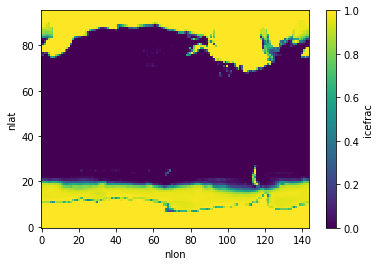

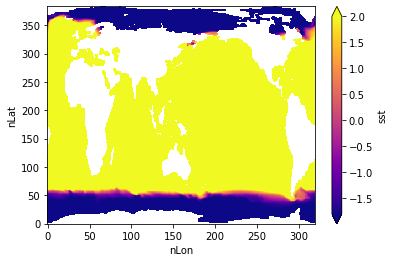

In [25]:
lgm_ice_adj.icefrac[8].plot()
plt.show()
lgm_sst_climo.sst[8].plot(vmin=-1.8,vmax=2,cmap='plasma')
plt.show()

In [ ]:
msel=8
# for msel in range(12):

# msel=2
mstr = str(msel+1).zfill(2)

path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
merged_load = xr.open_dataset(path + 
                                 'lgmDA_lgm_SST_monthly_climo_merged_' + mstr +'.nc')
merged_load = merged_load.sst

ds = lgm_sst_climo.sst[msel]
ds_ice = lgm_ice_climo.icefrac[msel]

ds_holo = holo_sst_climo.sst[msel]
ds_ice_holo = holo_ice_climo.icefrac[msel]
ds_ice_holo_wmask = holo_ice_climo

ds_temp_icegrid = regridder(ds)
ds_holo_icegrid = regridder_holo(ds_holo)
ds_temp_icegrid['mask'] = ~np.isnan(ds_temp_icegrid)
ds_holo_icegrid['mask'] = ~np.isnan(ds_holo_icegrid)

merged_icegrid = regridder_holo(merged_load)
merged_icegrid['mask'] = xr.where(~np.isnan(merged_icegrid),1,0)
merged_load['mask'] = xr.where(~np.isnan(merged_load),1,0)

## extrapolate the regridding to cover all cells with sea ice, since there 
## are some sea ice locations that show up as nan SST
newgrid = holo_ice_climo.icefrac[msel]
newgrid = newgrid.to_dataset()
newgrid['icefrac'] = newgrid.icefrac.where(newgrid.icefrac > 0.01)
newgrid['mask'] = xr.where(~np.isnan(newgrid.icefrac),1,0)
newgrid

data_for_regridding = merged_load.drop('mask').to_dataset(name='sst')
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)
data_for_regridding

regridder_extrap = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',
                         filename='bilinear_mergedSST_to_holoSIC_per_extrapID.nc',
                         reuse_weights=True)

merged_icegrid_extrap = regridder_extrap(data_for_regridding)

## this now has all of the places where we need sea ice
merged_icegrid = xr.where(
    np.isnan(merged_icegrid_extrap.sst),
    merged_icegrid,merged_icegrid_extrap.sst)
merged_icegrid['mask'] = xr.where(~np.isnan(merged_icegrid),1,0)

## subset data to fit SIC vs. SST lowess relation; only use NH for fit
#     sub_sic = ds_ice.where(ds_ice.lat > 10).values[
#         (ds_ice>0.01) & (ds_temp_icegrid > -1.78) & (ds_temp_icegrid < 1.5)]
#     sub_sst = ds_temp_icegrid.where(ds_temp_icegrid.lat > 10).values[
#         (ds_ice>0.01) & (ds_temp_icegrid > -1.78) & (ds_temp_icegrid < 1.5)]
# use holocene data for the fit since more relevant to infilling
sub_sic = ds_ice_holo.where(ds_holo_icegrid.lat > 10).values[
    (ds_ice_holo>0.01) & (ds_holo_icegrid > -1.8) & (ds_holo_icegrid < 3)]
sub_sst = ds_holo_icegrid.where(ds_holo_icegrid.lat > 10).values[
    (ds_ice_holo>0.01) & (ds_holo_icegrid > -1.8) & (ds_holo_icegrid < 3)]


## lowess regression in seaborn
df = pd.DataFrame(np.vstack([sub_sst,sub_sic]).T,columns=['sst','sic'])

f = sns.regplot(x='sst', y='sic',data=df,
                lowess=True, scatter_kws={"alpha": 0.1,'color':'k'},color='royalblue')
fit = f.lines[0].get_xydata()
plt.clf()

## adjust fit to manually add on ends to -2,100% and 1.0,0%
xfit = np.append(np.linspace(-2,fit[:,0][0],5),
                 np.append(fit[:,0],3))
yfit = np.append(np.linspace(1,fit[:,1][1],5),
                 np.append(fit[:,1],0))
yfit = np.clip(yfit,0,1)  ## prevent getting icefrac outside of 0 to 1

## where masks are different (and there isnt ice already), need to check for new ice

## lgm mask: either there is an SST from regridded, or there is more than 1% ice
# NB: need to add the 1% ice check because native ice grid appears to have
# sea ice where regridding yields land
lgmmask = ~np.isnan(ds_temp_icegrid) | (ds_ice > 0.01)
# lgmmask.plot()
# plt.show()

## new mask is all of the new, regridded SSTs where there could be sea ice
newmask = ~np.isnan(merged_icegrid)
# newmask.plot()
# plt.show()

## diffmask is only places where sea ice should potentially be added
diffmask = xr.where((newmask > 0) & (lgmmask < 1),1,0)
# diffmask.plot()
# plt.show()

## get all of the SSTs for cells that were previously masked
sst_ofnewice = merged_icegrid.where(diffmask==1)

## NORTHERN HEMISPHERE
## find closest SIC based on lowess fit
yind = np.argmin(
    (sst_ofnewice.values[:,:,np.newaxis] - xfit)**2,axis=2)
newsic = yfit[yind.ravel()].reshape(yind.shape)
icecombo = xr.where(diffmask != 0, newsic, ds_ice)

## SOUTHERN HEMISPHERE
## use xesmf extrapolation
newgrid = holo_ice_climo.icefrac[msel]
newgrid = newgrid.to_dataset()
newgrid['icefrac'] = newgrid.icefrac.where(newgrid.icefrac > 0.01)
newgrid['mask'] = xr.where(~np.isnan(newgrid.icefrac),1,0)
newgrid

data_for_regridding = ds_ice.to_dataset(name='icefrac')
data_for_regridding['mask'] = xr.where(~np.isnan(ds_temp_icegrid) | (ds_ice>0.01),1,0)
data_for_regridding['icefrac'] = data_for_regridding.icefrac.where(data_for_regridding.mask > 0)
data_for_regridding

regridder_SICextrap = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8*4,
#                          filename='bilinear_mergedSST_to_holoSIC_per_extrapID.nc',
                         reuse_weights=False)

ice_extrap = regridder_SICextrap(data_for_regridding)

diffmask2 = xr.where((newgrid.mask > 0) & 
                 (newgrid.mask != data_for_regridding.mask),1,0)

merged_icegrid2 = xr.where(diffmask2 != 0, ice_extrap.icefrac, ds_ice)

merged_icegrid2['mask'] = xr.where(~np.isnan(merged_icegrid2),1,0)

## put NH and SH together
icecombo2 = xr.where(icecombo.lat < 0, merged_icegrid2, icecombo)

#### ICE SHEET ADJ
## set minimum icefrac to be ice sheet frac
icecombo2 = xr.where(icecombo2*100 < ice6g_regrid.sftgif.values, 
                           ice6g_regrid.sftgif.values/100, icecombo2)

#### ICE SHEET ADJ
## set minimum icefrac to be ice sheet frac
icecombo2 = xr.where(icecombo2*100 < ice6g_regrid.sftgif.values, 
                           ice6g_regrid.sftgif.values/100, icecombo2)

## adjustment along meridians to patch in gaps
latmin=68
for imer,val in enumerate(icecombo2.transpose('nLon',...)):
    valnh = val.where(val.lat > latmin)

    ## check maximum ice poleward and equatorward, along meridian
    max_ice_poleward = np.array([valnh[j:].max() for j in range(len(valnh))])
    max_ice_equatorward = np.array([valnh[0:j+1].max() for j in range(len(valnh))])

    ## ice ceiling is maximum value ice will increase to. don't go below the original
    ## ice value, and don't go above the maximum SIC poleward of position
    ice_ceiling = np.array([np.max([p,v]) for p,v in zip(max_ice_poleward,valnh)])
    max_ice_equatorward = np.where((max_ice_equatorward > valnh) & (max_ice_equatorward > ice_ceiling), 
                               ice_ceiling, max_ice_equatorward)

    val = xr.where(val.lat > latmin, max_ice_equatorward, val)
    icecombo2[:,imer] = val

icecombo_all.icefrac[msel] = icecombo2
print(msel)

In [ ]:
## save files
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
fname = 'lgmDA_lgm_ICEFRAC_monthly_climo_merged_v3.nc'

icecombo_all.to_netcdf(savepath + fname)
print('finished saving')

In [ ]:
## PLOTTING TO CHECK RESULTS
# proj = ccrs.NorthPolarStereo()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_temp_icegrid,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Original SST from LGM on ice grid')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Ice in LGM (no actual mask for SIC data)')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice.where(lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Original Ice in LGM with Implied Mask')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice.where(newmask | lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('New Ocean Mask, Original LGM Ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                (diffmask*1).where(newmask | lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap='cividis',alpha=1)
# plt.title('Possible new locations for sea ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                icecombo,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Infilled Ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 40, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice_holo,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Holocene reference')
# plt.colorbar()
# plt.show()

# proj = ccrs.SouthPolarStereo()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_temp_icegrid,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Original SST from LGM on ice grid')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Ice in LGM (no actual mask for SIC data)')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice.where(lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Original Ice in LGM with Implied Mask')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice.where(newmask | lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('New Ocean Mask, Original LGM Ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                (diffmask*1).where(newmask | lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap='cividis',alpha=1)
# plt.title('Possible new locations for sea ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                icecombo,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Infilled Ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice_holo,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Holocene reference')
# plt.colorbar()
# plt.show()